<a href="https://colab.research.google.com/github/DirkStulgies/mlwtSportsPrediction/blob/main/sport_prediction_alex_presentation_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount gdrive 
from google.colab import drive
drive._mount('/content/gdrive')

# Package installation and import.
* pathlib: For working with directories.
* pandas: For reading, modifying and writing data.
* numpy: For converting the data into a format that can be easier understood by tensorflow.
* tensorflow: For creating and using the neural net.
* tensorboard: For visualizing the results.
* matplotlib: For visualizing the results.

In [ ]:
# Install the needed packages
%pip install pathlib2 pandas numpy tensorflow tensorboard --quiet

# Import packages.
import os
import signal
import tempfile
from pathlib2 import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorboard as tb

# Introduction to Dataset and Visualization

* Loading the SPI Dataset and doing basic preprocessing

In [ ]:
### load dataset and shuffle
df = pd.read_csv("https://raw.githubusercontent.com/lxndrshm/DBminutes/main/spi_matches.csv")
dataset = df.copy()
dataset = dataset.sample(frac=1)

In [ ]:
### dropping all the coloums we dont need. We can also drop more coloums like importance
df = df.drop(["adj_score1", "adj_score2","proj_score1", "proj_score2", "season", "date", "league_id", "team1", "team2"], axis = 1)
### drop NA´s (keep in mind, that this drops all unplayed games for now, e.g the games we wanna predict in the future)
df = df.dropna()

## Prepare new coloumns with Result, Projected Result and Accuracy

In [ ]:
#get the highest value from the probabilites to identify predicted result
df["maxValue"] = df.iloc[:, [3,4,5]].max(axis=1)

In [ ]:
# assign a probability tier
conditions = [
    (df['maxValue'] <= 0.1),
    (df['maxValue'] > 0.1) & (df['maxValue'] <= 0.2),
    (df['maxValue'] > 0.2) & (df['maxValue'] <= 0.3),
    (df['maxValue'] > 0.3) & (df['maxValue'] <= 0.4),
    (df['maxValue'] > 0.4) & (df['maxValue'] <= 0.5),
    (df['maxValue'] > 0.5) & (df['maxValue'] <= 0.6),
    (df['maxValue'] > 0.6) & (df['maxValue'] <= 0.7),
    (df['maxValue'] > 0.7) & (df['maxValue'] <= 0.8),
    (df['maxValue'] > 0.8) & (df['maxValue'] <= 0.9),
    (df['maxValue'] > 0.9)
    ]

# create a list of the values we want to assign for each condition
values = ['0.05', '0.15', '0.25', '0.35', '0.45', '0.55', '0.65', '0.75', '0.85', '0.95']

# create a new column and use np.select to assign values to it using our lists as arguments
df['tier'] = np.select(conditions, values)
#change datatype
df["tier"] = df['tier'].astype(str).astype(float)

In [ ]:
### Create a new result coloumn
# create a list of our conditions
conditions = [
    (df['score1'] > df["score2"]),
    (df['score1'] < df["score2"]),
    (df['score1'] == df["score2"])
    ]
# create a list of the values we want to assign for each condition
values = ['Homewin', 'Awaywin', 'Draw']

# create a new column and use np.select to assign values to it using our lists as arguments
df['result'] = np.select(conditions, values)

In [ ]:
#make a new coloumn with a projected result from prediction
dct = {'prob1': 'Homewin', 'prob2': 'Awaywin', 'probtie': 'Draw'}
df["proj_result"] = df[["prob1", "prob2", "probtie"]].idxmax(axis=1).map(dct)

In [ ]:
### check if result and proj_result are the same
# create a list of our conditions
conditions = [
    (df['result'] != df["proj_result"]),
    (df['result'] == df["proj_result"])
    ]
# create a list of the values we want to assign for each condition
values = ['False', "Correct"]

# create a new column and use np.select to assign values to it using our lists as arguments
df['acc'] = np.select(conditions, values)

In [ ]:
#code for visualizing accuracy per probability tier
probacc = df.groupby('tier')['acc'].value_counts(normalize=True, sort=False).unstack()
probacc = probacc.drop(["False"], axis = 1)
#probacc.plot(kind="bar")

In [ ]:
# code for accuracy per league
leagues = df.groupby('league')['acc'].value_counts(normalize=True, sort=True).unstack()
leagues["correct"] = leagues["False"]
leagues = leagues.drop(["False", "Correct"], axis = 1)
leagues = leagues.sort_values(by=["correct"])

### SPORTS PREDICTION WITH A NEURAL NET

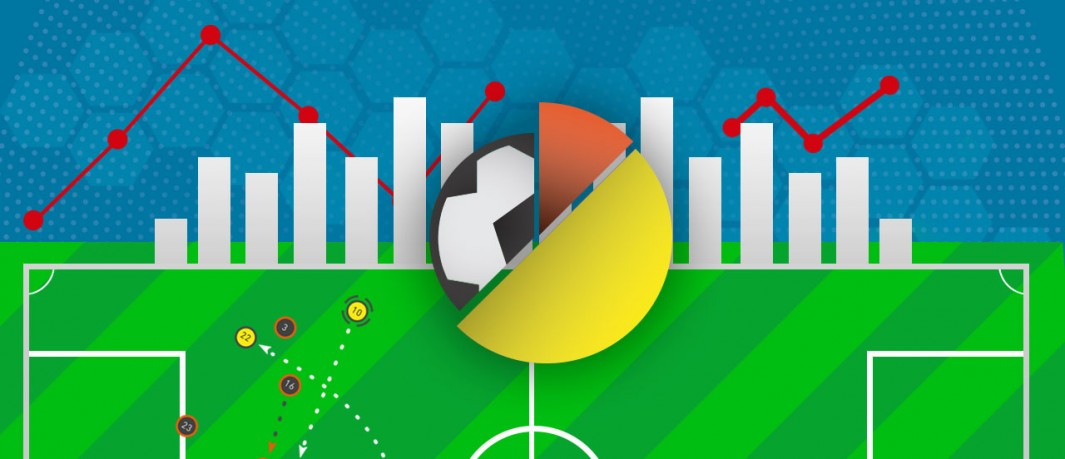

## Visualize Dataset and Accuracy for each Tier, League and Overall

In [ ]:
#datahead
dataset.head()

,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,probtie,proj_score1,proj_score2,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
40305,2020,2021-02-27,1871,Spanish Segunda Division,Logrones,Mallorca,24.37,51.30,0.1519,0.5791,0.2690,0.68,1.61,49.6,73.4,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
26154,2019,2019-10-19,2417,Scottish Premiership,St Mirren,St Johnstone,18.98,19.85,0.4218,0.2941,0.2841,1.20,0.95,47.3,43.4,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7110,2017,2018-01-06,1975,Mexican Primera Division Torneo Clausura,Necaxa,Veracruz,39.88,32.04,0.5097,0.1938,0.2964,1.40,0.75,47.8,57.8,0.0,0.0,0.43,0.33,0.87,0.72,0.00,0.00
29903,2019,2020-02-09,1846,German 2. Bundesliga,SpVgg Greuther Fürth,Hannover 96,31.88,38.26,0.3485,0.3716,0.2800,1.37,1.42,15.0,18.7,1.0,3.0,2.20,1.48,1.73,0.51,0.84,2.63
23592,2019,2019-08-16,1844,French Ligue 2,Paris FC,Niort,31.20,25.00,0.4791,0.1980,0.3229,1.26,0.70,20.7,25.9,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


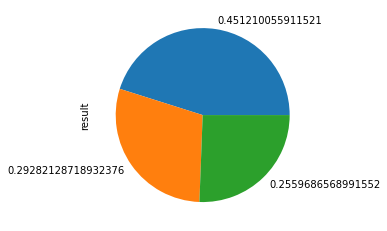

In [ ]:
#win probabilties distribution
distribution = df["result"].value_counts(normalize=True)
distribution.plot(kind="pie", labels=distribution)

In [ ]:
distribution

Homewin    0.451210
Awaywin    0.292821
Draw       0.255969
Name: result, dtype: float64

## Accuracy of SPI Model

In [ ]:
#accuracy of SPI Model
df['acc'].value_counts(normalize=True)

Correct    0.5141
False      0.4859
Name: acc, dtype: float64

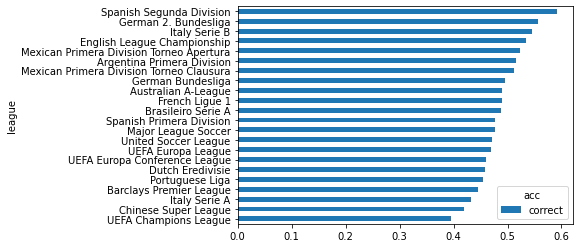

In [ ]:
#Visual for Accuracy per League
leagues.plot(kind="barh")

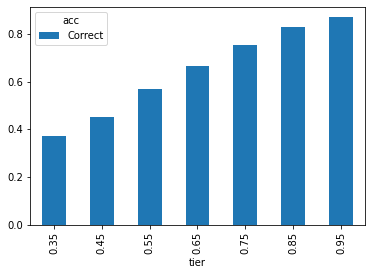

In [ ]:
#Visual for Accuracy per Tier
probacc.plot(kind="bar")

# Defining the parameter.
## Path for data files.
* DATA_FOLDER: Folder with the data files.
* FIVETHIRTYEIGHT_PROJECTS_FILE: A file downloaded from https://projects.fivethirtyeight.com. 
* MARKET_VALUE_FILE: A file containing the market value of each team, the average age of the players, etc. This information is taken from https://www.transfermarkt.com.
* POINTS_FILE: A file containing information about how many points and which rank each team had in the last season. This information is taken from https://www.sport.de/fussball/deutschland-bundesliga and http://www.trainer-baade.de/alle-aufsteiger-in-die-1-bundesliga/.
* PREPARED_DATA_FILE: The file containing the data, that is used for the neural net.

## Column names and values.
* FILTER_COLUMN: Column name for filtering the fivethirtyeight data set.
* FILTER_VALUE: Value for filtering the fivethirtyeight data set. 
* RESULT_COLUMN: The column for storing the calculated result of each match.
* RESULT_HEADERS: The column headers for the predicted results.
* RESULT_INFO_COLUMNS: Columns that are shown together with the predicted results.
* VALUE_COLUMNS: Not category columns, that are used for the neural net.
* VALUE_HOME_DRAW: The value of the RESULT_COLUMN, if the match result is a draw.
* VALUE_HOME_LOST: The value of the RESULT_COLUMN, if team 1 lost.
* VALUE_HOME_WON: The value of the RESULT_COLUMN, if team 1 won.

In [ ]:
# Path for data files.
DATA_FOLDER = '/content/gdrive/MyDrive/data'
FIVETHIRTYEIGHT_PROJECTS_FILE = os.path.join(DATA_FOLDER, 'spi_matches.csv')
MARKET_VALUE_FILE = os.path.join(DATA_FOLDER, 'market_value_soccer_german_federal_league.txt')
POINTS_FILE = os.path.join(DATA_FOLDER, 'points_soccer_german_federal_league.txt')
PREPARED_DATA_FILE = os.path.join(DATA_FOLDER, 'own_data.csv')

# Column names and values.
FILTER_COLUMN = 'league'
FILTER_VALUE = 'German Bundesliga'
RESULT_COLUMN = 'result_team1'
RESULT_HEADERS = ['loss_team1', 'draw', 'win_team1']
RESULT_INFO_COLUMNS = ['season', 'date', 'team1', 'team2']
VALUE_COLUMNS = [
    'average_age',
    'points_last_season',
    'points_this_season',
    'rank_last_season',
    'squad',
    'total_market_value_in_euro'
    ]
VALUE_HOME_DRAW = 1
VALUE_HOME_LOST = 0
VALUE_HOME_WON = 2

## Read the fivethirtyeight file and calculate the match result, the match day and this season points.
### Description
The data from fivethirtyeight projects was taken as a basis for creating a own data set. From this data only the season, the date of the match, the club names and the score made in each match were kept. Based on this columns the match day, the match result and the points were calculated.

### Process
1. Load the file and keep only the rows for the 1. federal league and only searten columns.
2. Sort the data by date and reset the index.
3. Create a new column for the match result and set it value for each row. The match result is calculated on the scores made by each team in this match.
4. Create new columns for the points made in this season and the match day. Calculate the values by looping over each row of the data set.

In [ ]:
# Read the fivethirtyeight file.
matches = pd.read_csv(FIVETHIRTYEIGHT_PROJECTS_FILE, delimiter=',', decimal='.')

# Filter the matches by the league.
matches = matches.loc[matches[FILTER_COLUMN] == FILTER_VALUE]

# Keep only the needed columns.
matches = matches.loc[:, ['season', 'date', 'team1', 'team2', 'score1', 'score2']]

# Sort the data by date.
matches.sort_values(by=['date'], ascending=True, inplace=True)

# Reset the data frame index.
matches.reset_index(inplace=True)

# Add the result column and calculate the value.
matches[RESULT_COLUMN] = None
matches.loc[matches['score1'] < matches['score2'], RESULT_COLUMN] = VALUE_HOME_LOST
matches.loc[matches['score1'] == matches['score2'], RESULT_COLUMN] = VALUE_HOME_DRAW
matches.loc[matches['score1'] > matches['score2'], RESULT_COLUMN] = VALUE_HOME_WON

# Create new columns for adding match days and points in this season.
matches['match_day_team1'] = None
matches['match_day_team2'] = None
matches['points_this_season_team1'] = None
matches['points_this_season_team2'] = None

# Get a list of all teams and seasons.
seasons = matches['season'].unique()
teams = matches['team1'].unique()

# Loop over each season and team and update the matches and point in the data set.
for season in seasons:
    for team in teams:
        points = 0
        match = 0
        for idx, row in matches.iterrows():
            result = matches.loc[idx, RESULT_COLUMN]

            # Get only the column for this season and this team as team1.
            if matches.loc[idx,'season'] == season and matches.loc[idx,'team1'] == team:
                # Update the played matches for team 1.
                match += 1
                matches.loc[idx,'match_day_team1'] = match

                # Update the points for team 1.
                if result == 1:
                    points += 1
                elif result == 2:
                    points += 3
                matches.loc[idx,'points_this_season_team1'] = points

            # Get only the column for this season and this team as team2.
            if matches.loc[idx,'season'] == season and matches.loc[idx,'team2'] == team:
                # Update the played matches for team 2.
                match += 1
                matches.loc[idx,'match_day_team2'] = match

                # Update the points for team 2.
                if result == 1:
                    points += 1
                elif result == 0:
                    points += 3
                matches.loc[idx,'points_this_season_team2'] = points

# Print the created table.
matches.head()

,index,season,date,team1,team2,score1,score2,result_team1,match_day_team1,match_day_team2,points_this_season_team1,points_this_season_team2
0,70,2016,2016-08-26,Bayern Munich,Werder Bremen,6.0,0.0,2,1,1,3,0
1,75,2016,2016-08-27,Hamburg SV,FC Ingolstadt 04,1.0,1.0,1,1,1,1,1
2,76,2016,2016-08-27,Eintracht Frankfurt,Schalke 04,1.0,0.0,2,1,1,3,0
3,77,2016,2016-08-27,FC Augsburg,VfL Wolfsburg,0.0,2.0,0,1,1,0,3
4,78,2016,2016-08-27,FC Cologne,SV Darmstadt 98,2.0,0.0,2,1,1,3,0


## Add columns regarding club value, average age, etc.
### Description
Data regarding the club value, the average age of the players, etc. was taken from the website http://www.transfermarkt.com. The data were manually stored in a separate file containing the values for each season from 2015 to 2021. Merging the data with the already existing data was done in two steps, first the data was added for team 1 and then for team 2.

### Process
1. Load the file.
2. Merge the new data for team 1 based on the columns season=season and team1=club.
3. Merge the new data for team 2 based on the columns season=season and team2=club.

In [ ]:
# Read the file with the market values.
market = pd.read_csv(MARKET_VALUE_FILE, delimiter='\t', decimal='.')

# Merge the columns from the market file for team 1.
matches_market_half = pd.merge(matches, market, left_on=['season', 'team1'], right_on=['season', 'club'])

# Merge the columns from the market file for team 2.
matches_market_full = pd.merge(matches_market_half, market, left_on=['season', 'team2'], right_on=['season', 'club'], suffixes=('_team1', '_team2'))

# Print the created table.
matches_market_full.head()

,index,season,date,team1,team2,score1,score2,result_team1,match_day_team1,match_day_team2,...,average age_team1,foreigners_team1,average market value in euro_team1,total market value in euro_team1,club_team2,squad_team2,average age_team2,foreigners_team2,average market value in euro_team2,total market value in euro_team2
0,70,2016,2016-08-26,Bayern Munich,Werder Bremen,6.0,0.0,2,1,1,...,25.1,18,18040000,595400000,Werder Bremen,41,24.5,20,1830000,75080000
1,707,2016,2016-11-26,Hamburg SV,Werder Bremen,2.0,2.0,1,12,12,...,23.6,20,2500000,94980000,Werder Bremen,41,24.5,20,1830000,75080000
2,1756,2016,2017-04-07,Eintracht Frankfurt,Werder Bremen,2.0,2.0,1,28,28,...,23.1,22,1890000,66100000,Werder Bremen,41,24.5,20,1830000,75080000
3,1225,2016,2017-02-05,FC Augsburg,Werder Bremen,3.0,2.0,2,19,19,...,25.3,21,1870000,69030000,Werder Bremen,41,24.5,20,1830000,75080000
4,2154,2016,2017-05-05,FC Cologne,Werder Bremen,4.0,3.0,2,32,32,...,24.4,13,2580000,77400000,Werder Bremen,41,24.5,20,1830000,75080000


## Add columns regarding points and rank last season.
### Description
Data regarding points and ranks last season was taken from the website https://www.sport.de/fussball/deutschland-bundesliga. Clubs that joined the 1. federal league in the next season, were added as rank 19 and 20 with 0 points. The information about which clubs to add came from http://www.trainer-baade.de/alle-aufsteiger-in-die-1-bundesliga/. The data were manually stored in a separate file containing the values for each season from 2015 to 2021.

Because the data added in this step are meant to add information about the last season, the season value was increased by one before merging the data. Merging the data with the already existing data was done in two steps, first the data was added for team 1 and then for team 2. After merging the data, a new column containing the points of the last season divided by the match day in this season was added.

### Process
1. Load the file.
2. Increase the season by one and change the column names.
3. Merge the new data for team 1 based on the columns season=season and team1=club.
4. Merge the new data for team 2 based on the columns season=season and team2=club.
5. Add a new column, containing the points of the last season divided by the match day in this season.

In [ ]:
# Read in the file with the points and ranks.
points = pd.read_csv(POINTS_FILE, delimiter='\t', decimal='.')

# Preparing the data to be merged with the data from the next season.
points['season'] = points['season'] + 1
points.rename(columns={'points': 'points_last_season_all', 'rank': 'rank_last_season'}, inplace=True)

# Merge the columns from the points file for team 1.
matches_market_points_half = pd.merge(matches_market_full, points, left_on=['season', 'team1'], right_on=['season', 'club'])

# Merge the columns from the points file for team 2.
matches_market_points_full = pd.merge(matches_market_points_half, points, left_on=['season', 'team2'], right_on=['season', 'club'], suffixes=('_team1', '_team2'))

# For each row the points from the last season are divided by the math day in this season.
matches_market_points_full['points_last_season_team1'] = matches_market_points_full['points_last_season_all_team1'] / matches_market_points_full['match_day_team1']
matches_market_points_full['points_last_season_team2'] = matches_market_points_full['points_last_season_all_team2'] / matches_market_points_full['match_day_team2']

# Print the created table.
matches_market_points_full.head()

/tmp/ipykernel_4832/789736296.py:12: FutureWarning: Passing 'suffixes' which cause duplicate columns {'club_team1'} in the result is deprecated and will raise a MergeError in a future version.
  matches_market_points_full = pd.merge(matches_market_points_half, points, left_on=['season', 'team2'], right_on=['season', 'club'], suffixes=('_team1', '_team2'))


,index,season,date,team1,team2,score1,score2,result_team1,match_day_team1,match_day_team2,...,average market value in euro_team2,total market value in euro_team2,rank_last_season_team1,club_team1,points_last_season_all_team1,rank_last_season_team2,club_team2,points_last_season_all_team2,points_last_season_team1,points_last_season_team2
0,70,2016,2016-08-26,Bayern Munich,Werder Bremen,6.0,0.0,2,1,1,...,1830000,75080000,1,Bayern Munich,88,13,Werder Bremen,38,88.0,38.0
1,707,2016,2016-11-26,Hamburg SV,Werder Bremen,2.0,2.0,1,12,12,...,1830000,75080000,10,Hamburg SV,41,13,Werder Bremen,38,3.416667,3.166667
2,1756,2016,2017-04-07,Eintracht Frankfurt,Werder Bremen,2.0,2.0,1,28,28,...,1830000,75080000,16,Eintracht Frankfurt,36,13,Werder Bremen,38,1.285714,1.357143
3,1225,2016,2017-02-05,FC Augsburg,Werder Bremen,3.0,2.0,2,19,19,...,1830000,75080000,12,FC Augsburg,38,13,Werder Bremen,38,2.0,2.0
4,2154,2016,2017-05-05,FC Cologne,Werder Bremen,4.0,3.0,2,32,32,...,1830000,75080000,9,FC Cologne,43,13,Werder Bremen,38,1.34375,1.1875


## Final data preparations.
### Description
In this step, the difference between the feature values of team 1 and team 2 are calculated. Those differences are then normalized. To normalize the data, min and max value for the features are determined. After this, the sum of the row and the min value is divided by the sum of the max and min value. 

Before storing the data to file, it is again sorted by date and only intended columns are kept.

### Process
1. Replace all space characters in the column names.
2. Calculate the team difference for each feature.
3. Normalize the calculated columns.
4. Sort the data and reset the index.
5. Get only the intended columns.
6. Store the data to file.

In [ ]:
# Remove space characters in the column names.
matches_market_points_full.columns = matches_market_points_full.columns.str.replace(' ', '_')

# Calculate the difference between team1 and team2 for each feature.
for column in VALUE_COLUMNS:
    matches_market_points_full[column] = matches_market_points_full[column + '_team1'] - matches_market_points_full[column + '_team2']

# Normalize the feature values.
for column in VALUE_COLUMNS:
    abs_min_value = abs(matches_market_points_full[column].min())
    max_value = matches_market_points_full[column].max()
    matches_market_points_full[column] = matches_market_points_full[column].apply(lambda x: (x+abs_min_value)/(max_value+abs_min_value))

# Sort the data by date.
data = matches_market_points_full.sort_values(by=['date'], ascending=True)

# Reset the data frame index.
data.reset_index(inplace=True)

# Keep only the columns for the neural net.
data = data.loc[:, RESULT_INFO_COLUMNS + VALUE_COLUMNS + [RESULT_COLUMN]]

# Store the new data table as file.
data.to_csv(PREPARED_DATA_FILE, index=False)

# Print the created table.
data.head()

,season,date,team1,team2,average_age,points_last_season,points_this_season,rank_last_season,squad,total_market_value_in_euro,result_team1
0,2016,2016-08-26,Bayern Munich,Werder Bremen,0.569767,0.913386,0.550847,0.200,0.277778,0.793784,2
1,2016,2016-08-27,FC Cologne,SV Darmstadt 98,0.348837,0.559055,0.550847,0.375,0.250000,0.525165,2
2,2016,2016-08-27,Borussia Dortmund,Mainz,0.604651,0.740157,0.550847,0.400,0.277778,0.632884,2
3,2016,2016-08-27,FC Augsburg,VfL Wolfsburg,0.709302,0.464567,0.500000,0.600,0.333333,0.411738,0
4,2016,2016-08-27,Hamburg SV,FC Ingolstadt 04,0.476744,0.527559,0.525424,0.475,0.666667,0.532917,1


## Final features for the prediction.
* season: This column contains the year in which the season started (2016 = season from fall 2016 to summer 2017).
* date: The date of the match (YYYY-MM-DD).
* team1: The club name of team 1.
* team2: The club name of team 2.
* average_age: The average age of the players (normalized difference).
* points_last_season: Points of the last season (normalized difference).
* points_this_season: Points in this season (normalized difference).
* rank_last_season: Rank in the last season (normalized difference).
* squad: Squad size (normalized difference).
* total_market_value_in_euro: Total market value in euro (normalized difference).
* result_team1: The result of team 1 (0 = loss, 1 = draw, 2 = won).

# Outlook

* use more specific data (if the star player is injured, or who is playing on the field)

* go more in depth and check on odds for betting websites

* see if halftime predictions are worth pursuing

* more in depth error-analysis